In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [28]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8


In [22]:
dataset_renaming = {
    "mendelian_traits_matched_9": "Mendelian traits",
    "complex_traits_matched_9": "Complex traits",
}

subset_renaming = {
    "nonexonic_AND_distal": "Non-exonic\n(distal)",
    "nonexonic_AND_proximal": "Non-exonic\n(proximal)",
    "5_prime_UTR_variant": "5' UTR",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
}

In [37]:
datasets = [
    "mendelian_traits_matched_9",
    "complex_traits_matched_9",
]

subsets = [
    "nonexonic_AND_distal",
    "nonexonic_AND_proximal",
    "5_prime_UTR_variant",
    "3_prime_UTR_variant",
    "non_coding_transcript_exon_variant",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "Borzoi",
    "GPN-MSA",
    "CADD",
    "CADD+GPN-MSA+Borzoi",
]

def get_model_path(model, modality, dataset, subset):
    if modality == "Linear probing":
        predictor = f"{model}.LogisticRegression.chrom.subset_from_all"
    elif modality == "Zero-shot":
        if model == "CADD":
            predictor = "CADD.plus.RawScore"
        elif model in ["Enformer", "Borzoi"]:
            predictor = f"{model}_L2_L2.plus.all"
        else:
            if "mendelian" in dataset:
                llr_version = "LLR"
                sign = "minus"
            elif "complex" in dataset:
                llr_version = "absLLR"
                sign = "plus"
            predictor = f"{model}_{llr_version}.{sign}.score"
    return f"../../results/dataset/{dataset}/metrics_by_chrom_weighted_average/{subset}/{predictor}.csv"

In [51]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if modality == "Zero-shot" and "+" in model: continue
                model_for_path = model
                if "mendelian" in dataset and model == "CADD+GPN-MSA+Borzoi":
                    model_for_path = "CADD+GPN-MSA_LLR+Borzoi_L2_L2"
                path = get_model_path(
                    model_for_path,
                    modality,
                    dataset,
                    subset
                )
                df = pd.read_csv(path).iloc[0]
                rows.append([
                    dataset_renaming.get(dataset, dataset),
                    subset_renaming.get(subset, subset),
                    modality,
                    model_renaming.get(model, model),
                    df["score"],
                    df["se"],
                ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,Mendelian traits,Non-exonic\n(distal),Zero-shot,Borzoi,0.342290,0.138028
1,Mendelian traits,Non-exonic\n(distal),Zero-shot,GPN-MSA,0.819513,0.102417
2,Mendelian traits,Non-exonic\n(distal),Zero-shot,CADD,0.834884,0.079110
3,Mendelian traits,Non-exonic\n(distal),Linear probing,Borzoi,0.525521,0.086165
4,Mendelian traits,Non-exonic\n(distal),Linear probing,GPN-MSA,0.842287,0.105453
...,...,...,...,...,...,...
65,Complex traits,ncRNA,Zero-shot,CADD,0.351099,0.038837
66,Complex traits,ncRNA,Linear probing,Borzoi,0.357324,0.056027
67,Complex traits,ncRNA,Linear probing,GPN-MSA,0.398297,0.038063
68,Complex traits,ncRNA,Linear probing,CADD,0.330727,0.044400


In [52]:
def best_modality(df):
    res = df.sort_values("score", ascending=False).iloc[0]
    return res[["score", "se"]]

df = df.groupby(["dataset", "subset", "model"], sort=False).apply(best_modality).reset_index()
df

,dataset,subset,model,score,se
0,Mendelian traits,Non-exonic\n(distal),Borzoi,0.525521,0.086165
1,Mendelian traits,Non-exonic\n(distal),GPN-MSA,0.842287,0.105453
2,Mendelian traits,Non-exonic\n(distal),CADD,0.868153,0.120800
3,Mendelian traits,Non-exonic\n(distal),Ensemble,0.863676,0.122121
4,Mendelian traits,Non-exonic\n(proximal),Borzoi,0.715704,0.070709
5,Mendelian traits,Non-exonic\n(proximal),GPN-MSA,0.742770,0.034461
6,Mendelian traits,Non-exonic\n(proximal),CADD,0.925035,0.029053
7,Mendelian traits,Non-exonic\n(proximal),Ensemble,0.927874,0.036586
8,Mendelian traits,5' UTR,Borzoi,0.458049,0.067797
9,Mendelian traits,5' UTR,GPN-MSA,0.565152,0.111969


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

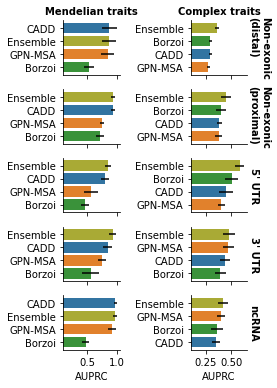

In [67]:
g = sns.FacetGrid(
    data=df.rename(columns={"score": "AUPRC"}),
    row="subset",
    col="dataset",
    margin_titles=True,
    sharex="col",
    sharey=False,
    height=1.1,
    aspect=1.8,
)

def my_boxplot(data, **kwargs):
    data = data.sort_values("AUPRC", ascending=False)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        palette=palette,
    )
    bar_height = g.patches[0].get_height()
    y_coords = sorted([bar.get_y() + bar_height / 2 for bar in g.patches])
    ax.errorbar(
        x=data["AUPRC"],
        y=y_coords,
        xerr=data["se"],
        fmt='none',
        color="black",
    )

g.map_dataframe(my_boxplot)
g.figure.subplots_adjust(hspace=0)

g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(
    col_template="{col_name}", row_template="{row_name}",
    fontweight="bold",
    #size=12,
)
g.tight_layout()
plt.savefig("../../results/plots/performance_by_consequence.pdf", bbox_inches="tight")